In [4]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mobilenet_1_0_224_tf_no_top.h5


In [5]:
!pip install gdown

In [6]:
import gdown

download_link = f'https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4'
gdown.download(download_link, 'dataset.zip', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4
From (redirected): https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4&confirm=t&uuid=fe288415-8a4e-47af-a8d1-87cb416782a3
To: /kaggle/working/dataset.zip
100%|██████████| 88.4M/88.4M [00:00<00:00, 175MB/s]


'dataset.zip'

In [7]:
!unzip "/kaggle/working/dataset.zip"

Archive:  /kaggle/working/dataset.zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/1073.jpeg  
  inflating: dataset/test/1090.jpeg  
  inflating: dataset/test/1132.jpeg  
  inflating: dataset/test/1133.jpeg  
  inflating: dataset/test/1153.jpeg  
  inflating: dataset/test/12.png     
  inflating: dataset/test/122.jpeg   
  inflating: dataset/test/1222.jpeg  
  inflating: dataset/test/1266.jpeg  
  inflating: dataset/test/1287.jpeg  
  inflating: dataset/test/1335.jpeg  
  inflating: dataset/test/134.jpeg   
  inflating: dataset/test/1348.jpeg  
  inflating: dataset/test/1411.jpeg  
  inflating: dataset/test/1413.jpeg  
  inflating: dataset/test/1415.jpeg  
  inflating: dataset/test/1423.jpeg  
  inflating: dataset/test/1444.jpeg  
  inflating: dataset/test/1455.jpeg  
  inflating: dataset/test/1463.jpeg  
  inflating: dataset/test/1470.jpeg  
  inflating: dataset/test/1477.jpeg  
  inflating: dataset/test/1521.jpeg  
  inflating: dataset/test/1526.jpeg  
 

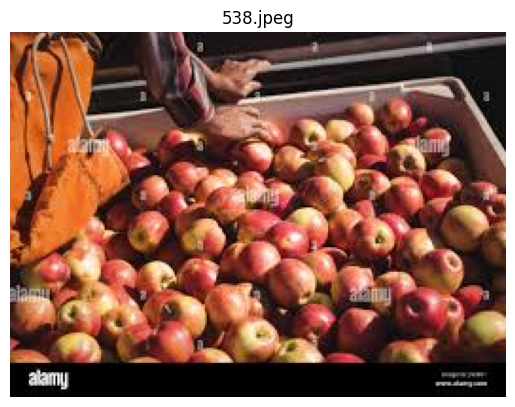

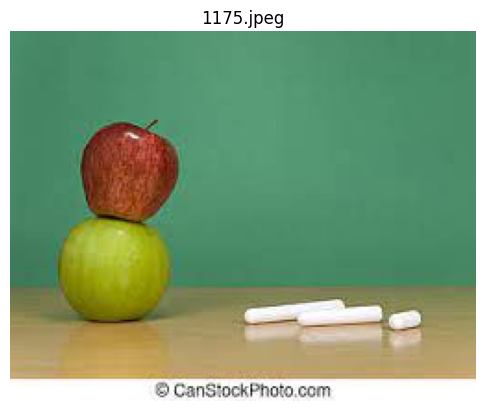

In [8]:
import os
import random  
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/kaggle/working/dataset/train"
def plot_images(directory, num_samples=2):
    image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(image_files, num_samples)
    for img_name in selected_images:
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)      
        # Display the image
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
        plt.show()

plot_images(os.path.join(dataset_path, '1'))

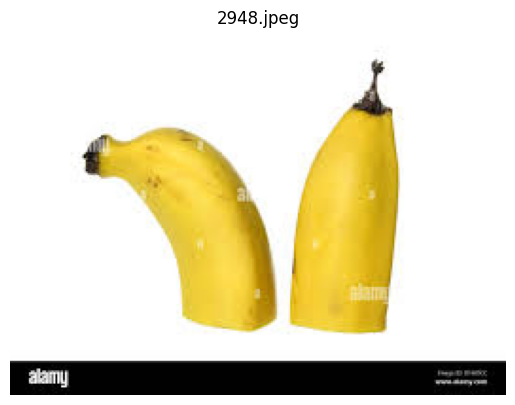

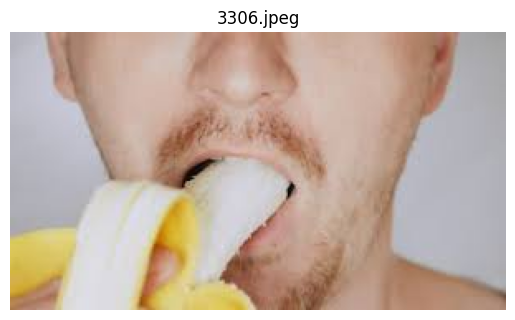

In [9]:
plot_images(os.path.join(dataset_path, '2'))

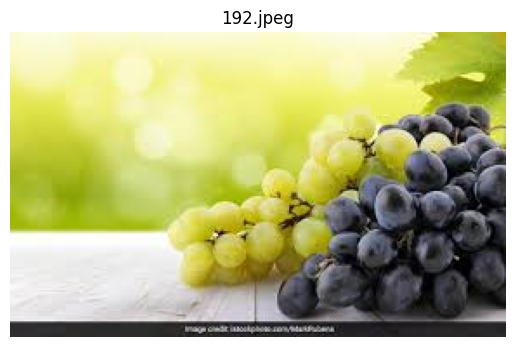

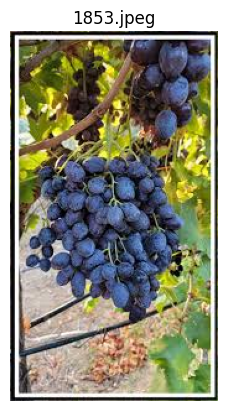

In [10]:
plot_images(os.path.join(dataset_path, '3'))

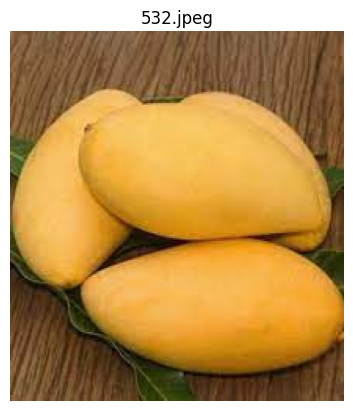

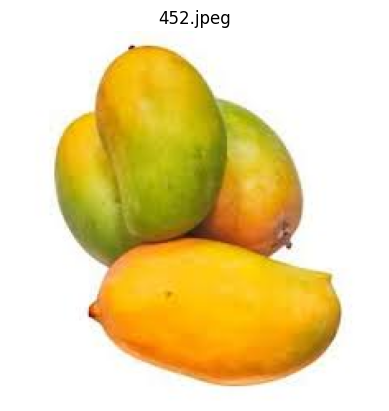

In [11]:
plot_images(os.path.join(dataset_path, '4'))

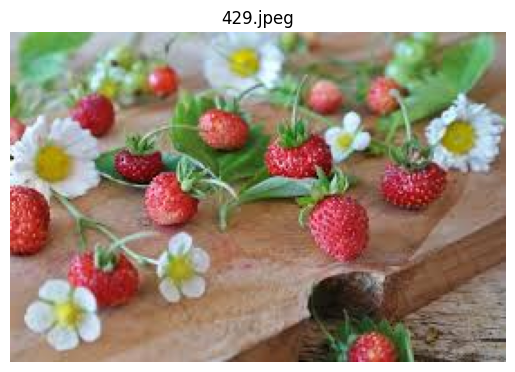

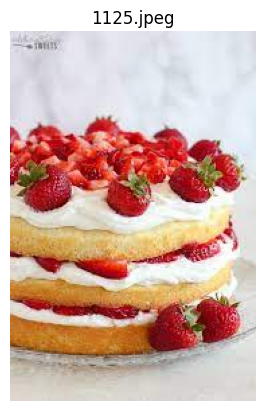

In [12]:
plot_images(os.path.join(dataset_path, '5'))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os

data = []
labels = []
IMG_SIZE = 224
data_path = '/kaggle/working/dataset/train/'

# Loop through class directories
for class_dir in os.listdir(data_path):
    class_path = os.path.join(data_path, class_dir)

    # Check if the item in the directory is a directory
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv.imread(img_path)
                if img is not None:
                    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
                    data.append(img)
                    labels.append(class_dir)
                else:
                    print(f"Error loading image: {img_path}")
            else:
                print(f"Skipping non-image file: {img_path}")

print(len(data))
print(len(labels))
print(labels[0])
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


9900
9900
3
7920
1980


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention

class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 16, 16, 1],
            strides=[1, 16, 16, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(Layer):
    def __init__(self, num_patches=196, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        class_token = tf.tile(self.class_token, multiples=[batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        encoded = patches_embed + positions_embed
        return encoded

class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        x1 = self.norm1(x)
        attention_output = self.attn(x1, x1)
        x2 = Add()([attention_output, x])
        x3 = self.norm2(x2)
        x3 = self.mlp(x3)
        y = Add()([x3, x2])
        return y

class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

def create_VisionTransformer(num_classes, num_patches=196, projection_dim=768, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    patches = PatchExtractor()(inputs)
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    transformer = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(transformer)
    logits = MLP(projection_dim, num_classes, 0.5)(representation)
    model = Model(inputs=inputs, outputs=logits)
    return model

model = create_VisionTransformer(5)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 patch_extractor (PatchExtr  (None, None, 768)         0         
 actor)                                                          
                                                                 
 patch_encoder (PatchEncode  (None, 197, 768)          742656    
 r)                                                              
                                                                 
 transformer_encoder (Trans  (None, 197, 768)          141743616 
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 768)               0         
 GlobalAveragePooling1D)                                     

In [3]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testX, testY)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
396/396 [==============================] - 448s 1s/step - loss: nan - accuracy: 0.1973 - val_loss: 9.7584 - val_accuracy: 0.2077
Epoch 2/20
396/396 [==============================] - 402s 1s/step - loss: nan - accuracy: 0.1984 - val_loss: 9.7584 - val_accuracy: 0.2210
Epoch 3/20
396/396 [==============================] - 401s 1s/step - loss: nan - accuracy: 0.2001 - val_loss: 9.6464 - val_accuracy: 0.2033
Epoch 4/20
396/396 [==============================] - 401s 1s/step - loss: nan - accuracy: 0.2071 - val_loss: 9.6464 - val_accuracy: 0.1982
Epoch 5/20
396/396 [==============================] - 401s 1s/step - loss: nan - accuracy: 0.1937 - val_loss: 9.6464 - val_accuracy: 0.2033
Epoch 6/20
396/396 [==============================] - 401s 1s/step - loss: nan - accuracy: 0.2074 - val_loss: 9.6464 - val_accuracy: 0.2519
Epoch 7/20
396/396 [==============================] - 401s 1s/step - loss: nan - accuracy: 0.2135 - val_loss: 9.5752 - val_accuracy: 0.1982
Epoch 8/20
396/396 [